In [1]:
# import libraries 
import nest
import nest.voltage_trace
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import pathlib
from collections import deque
import os

rng = np.random.default_rng(42)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug 27 2024 04:36:56

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
DATA_DIR = pathlib.Path('../Datasets/Original')

CELLTYPE_MAP = {
    'KCs': 'exc', 'PNs': 'exc', 'PNs-somato': 'exc',
    'LNs': 'inh', 'MB-FBNs': 'inh', 'MB-FFNs': 'inh',
    'pre-DN-SEZs': 'mixed', 'pre-DN-VNCs': 'mixed', 'RGNs': 'inh',
    'DN-VNCs': 'mixed', 'LHNs': 'exc',
    'MBONs': 'exc', 'MBINs': 'mod', 'DN-SEZs': 'mixed', 'CNs': 'mixed'
}

neuron_params = {
    'C_m': 250,
    'tau_m': 30,
    't_ref': 3,
    'E_L': -70,
    'V_reset': -70,
    'V_th': -55,
}

In [3]:
# load connectivity matrices
aa = pd.read_csv(DATA_DIR / 'aa_connectivity_matrix.csv', index_col=0)
ad = pd.read_csv(DATA_DIR / 'ad_connectivity_matrix.csv', index_col=0)
da = pd.read_csv(DATA_DIR / 'da_connectivity_matrix.csv', index_col=0)
dd = pd.read_csv(DATA_DIR / 'dd_connectivity_matrix.csv', index_col=0)

In [4]:
conn_mats = {
    'aa': aa,
    'ad': ad, 
    'da': da, 
    'dd': dd
}

In [5]:
def load_attributes() -> pd.DataFrame:
    # merge s3 and s4 tabls
    s3 = pd.read_csv(DATA_DIR / 's3.csv')
    s4 = pd.read_csv(DATA_DIR / 's4.csv')
    return s3.merge(s4, on='skid', how='left', suffixes=('_axon', '_dendrite'))

In [6]:
def build_graph(conn_mats: dict[str, pd.DataFrame]) -> nx.DiGraph:
    aa, ad, da, dd = conn_mats['aa'], conn_mats['ad'], conn_mats['da'], conn_mats['dd']
    G = nx.DiGraph()
    for nid in aa.index:
        G.add_node(int(nid))
    
    for pre_id in aa.index:
        for post_id in aa.columns:
            w_aa, w_ad = aa.loc[pre_id, post_id], ad.loc[pre_id, post_id]
            w_da, w_dd = da.loc[pre_id, post_id], dd.loc[pre_id, post_id]
            weight = w_aa + w_ad + w_da + w_dd 
            if weight > 0:
                G.add_edge(int(pre_id), int(post_id), weight=(weight))
                
    return G

In [7]:
def annotate_graph(G: nx.DiGraph, attr_df: pd.DataFrame,
                   inh_targer_perc: float = 0.20,
                   rng = None) -> None:
    rng = rng or random.Random(42)   
    
    # inhibitory/excitatory
    for nid in G.nodes:
        G.nodes[nid]['is_inh'] = None
        
    known_inh, candidates = set(), []
    for _, row in attr_df.iterrows():
        nid = int(row['skid'])
        if nid not in G: 
            continue
        ctype = str(row.get('celltype_axon', row.get('celltype')))
        tag = CELLTYPE_MAP.get(ctype, 'unknown')
        
        if tag == 'inh':
            G.nodes[nid]['is_inh'] = True
            known_inh.add(nid)
        elif tag == 'exc' or tag == 'unknown':
            G.nodes[nid]['is_inh'] = False
        else: # mixed/mod
            candidates.append(nid)
        
        total_n = len(G.nodes)
        target_inh = int(inh_targer_perc * total_n)
        remaining_inh = target_inh - len(known_inh)
    
        random.shuffle(candidates)
        selected_inh = set(candidates[:remaining_inh])
    
        for nid in candidates:
            G.nodes[nid]['is_inh'] = (nid in selected_inh)
    
        for nid in G.nodes:
            if G.nodes[nid]['is_inh'] is None:
                G.nodes[nid]['is_inh'] = False
                
    # is_input/is_output
    inp = pd.read_csv(DATA_DIR / 'inputs.csv',  index_col=0)
    out = pd.read_csv(DATA_DIR / 'outputs.csv', index_col=0)
    for nid in G:
        G.nodes[nid]['is_input']  = inp['axon_input'].get(nid, 0)  > 50
        G.nodes[nid]['is_output'] = out['axon_output'].get(nid, 0) > 50
    
    # signal depth 
    depth = {n:-1 for n in G.nodes}
    q = deque([n for n in G.nodes if G.nodes[n]['is_input']])
    for n in q: depth[n]=0
    while q:
        u=q.popleft()
        for v in G.successors(u):
            if depth[v]==-1:
                depth[v]=depth[u]+1
                q.append(v)
    for n in G.nodes: G.nodes[n]['signal_depth']=depth[n]
    
    # direction label
    def edge_dir(u,v):
        du,dv = depth[u], depth[v]
        if du<0 or dv<0: return 'unknown'
        if du<dv: return 'feedforward'
        if du>dv: return 'feedback'
        return 'lateral'
    
    for u,v,d in G.edges(data=True):
        d['signal_direction']=edge_dir(u,v) 

In [8]:
def create_nest_network(G: nx.DiGraph,
                        neuron_params: dict,
                        BASE_W: float = 1,
                        DELAY: float = 1.5,) -> tuple[list[int], dict[int, int]]:

    nest.ResetKernel()
    neurons = nest.Create('iaf_psc_alpha', G.number_of_nodes(), params=neuron_params)
    node_list = sorted(G.nodes())
    node_index = {nid: i for i, nid in enumerate(node_list)}

    for u, v, d in G.edges(data=True):
        w = d['weight']
        sign = -1 if G.nodes[u]['is_inh'] else 1
        weight = BASE_W * w * sign
        nest.Connect(
            neurons[node_index[u]:node_index[u]+1],
            neurons[node_index[v]:node_index[v]+1],
            syn_spec={'weight': weight, 'delay': DELAY}
        )
    return neurons, node_index

In [9]:
def connect_spike_recorder(neurons):
    spike_recorder = nest.Create('spike_recorder')
    nest.Connect(neurons, spike_recorder)
    return spike_recorder

In [10]:
def connect_dc_generator(
        stim_ids: list, neurons,
        node_index, stim_amp: float, 
        start: float, stop: float):
    dc = nest.Create('dc_generator', params={'amplitude': stim_amp, 'start': start, 'stop': stop})
    for nid in stim_ids:
        idx = node_index[nid]
        nest.Connect(dc, neurons[idx:idx+1])     

In [11]:
def connect_multimeter(neurons, interval: float = 0.5):
    mm = nest.Create('multimeter')
    nest.SetStatus(mm, [{
        'interval': interval,
        'record_from': ['V_m']
    }])
    nest.Connect(mm, neurons)
    return mm

In [12]:
def get_input_neuron_ids(G: nx.DiGraph) -> list[int]:
    return [nid for nid, data in G.nodes(data=True) if data.get('is_input', False)]

In [13]:
def prepare_graph(conn_mats):
    print('building graph...')
    G = build_graph(conn_mats)
    print(f'Graph: {len(G)} neurons,'
          f'with {G.number_of_nodes()} nodes')
    attr = load_attributes()
    print('annotating graph...')
    annotate_graph(G=G, attr_df=attr)
    return G

In [61]:
def run_experiment(
        G: nx.DiGraph,
        stim_start: float,
        stim_stop: float,
        tail: float,
        generator_amp: float = 600,
        stim_ids: list = None,
        BASE_W: float = 1,
        DELAY: float = 2.5,):
    sim_time = stim_stop + tail
    
    print('creating nest network...')
    neurons, node_index = create_nest_network(
        G=G, neuron_params=neuron_params, 
        BASE_W=BASE_W, DELAY=DELAY)
    spike_recorder = connect_spike_recorder(neurons)
    multimeter = connect_multimeter(neurons, interval=0.5)
    
    if stim_ids is None:                      
        stim_ids = get_input_neuron_ids(G)
        
    print(f'Stimulation of {len(stim_ids)} neurons ')
    connect_dc_generator(
        stim_ids=stim_ids, 
        neurons=neurons,
        node_index=node_index, 
        stim_amp=generator_amp, 
        start=stim_start, 
        stop=stim_stop
    )
    
    nest.Simulate(sim_time)
    
    events = nest.GetStatus(spike_recorder, 'events')[0]
    return events, multimeter, neurons, node_index 

In [ ]:
stim_start = 50
stim_stop = 500
tail = 1000
G = prepare_graph(conn_mats)
events, times = run_experiment(G=G, stim_start=stim_start, stim_stop=stim_stop, tail=tail, generator_amp=600, BASE_W=4.6, DELAY=2.5)

In [62]:
events, multimeter, neurons, node_index = run_experiment(G=G, stim_start=50, stim_stop=150, tail=1000, generator_amp=100, BASE_W=4.6, DELAY=2.5)

creating nest network...
Stimulation of 687 neurons 

May 25 14:05:12 NodeManager::prepare_nodes [Info]: 
    Preparing 2955 nodes for simulation.

May 25 14:05:12 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2955
    Simulation time (ms): 1150
    Number of OpenMP threads: 1
    Not using MPI

May 25 14:05:13 SimulationManager::run [Info]: 
    Simulation finished.


In [63]:
echo_duration(events['times'], stim_stop=150, sim_time=150+1000)

0.0

## REPORTS

In [56]:
def echo_duration(times: np.ndarray,
                  stim_stop: float,
                  sim_time: float,
                  quiet_ms: float = 20.0) -> float:
    post = times[times > stim_stop]
    if post.size == 0:
        return 0.0

    post_sorted = np.sort(post)
    gaps = np.diff(np.append(post_sorted, quiet_ms + sim_time))
    end_idx = np.argmax(gaps >= quiet_ms)
    echo_end = post_sorted[end_idx]
    return echo_end - stim_stop


In [ ]:
sim_time = stim_stop + 1000
echo_duration(times, sim_time=sim_time)

In [16]:
def spike_matrix(neurons, events: dict,
                 sim_time: float, bin_ms: float = 1.0):
    senders = events['senders']
    times = events['times']

    n_neurons = len(neurons)
    n_bins = int(np.ceil(sim_time / bin_ms))

    X = np.zeros((n_neurons, n_bins), dtype=np.int32)

    gid2row = {neurons[i].global_id: i for i in range(n_neurons)}
    bin_idx = (times // bin_ms).astype(int)
    bin_idx[bin_idx == n_bins] = n_bins - 1        

    for gid, b in zip(senders, bin_idx):
        X[gid2row[gid], b] += 1

    return X, gid2row

In [17]:
def save_activity_matrix(events: dict, neurons,
                         sim_time: float, bin_ms: float = 1.0,
                         fname: str = 'activity_matrix.csv') -> np.ndarray:
    X, _ = spike_matrix(neurons, events, sim_time, bin_ms)
    
    df = pd.DataFrame(X.T, columns=[f'neuron_{i}' for i in range(X.shape[0])])
    df.to_csv(fname, index_label='time_bin')
    
    print(f'{fname} saved')
    return X

In [18]:
def save_adj_matrix(G: nx.DiGraph,
                    node_index,
                    BASE_W: float = 1.0,
                    fname: str = 'adj.csv'):
    N = len(node_index)
    adj = np.zeros((N, N), dtype=np.float32)
    for u, v, d in G.edges(data=True):
        sign = -1 if G.nodes[u]['is_inh'] else 1
        adj[node_index[u], node_index[v]] = BASE_W * sign * d['weight']
    pd.DataFrame(adj,
                 index=list(node_index.keys()),
                 columns=list(node_index.keys())
                ).to_csv(fname)
    print(f'{fname} saved')

In [19]:
def save_vm_matrix(multimeter, fname: str = 'vm_matrix.csv'):
    events = nest.GetStatus(multimeter, 'events')[0]
    df = pd.DataFrame({
        'time': events['times'],
        'sender': events['senders'],
        'V_m': events['V_m']
    })

    pivot_df = df.pivot(index='time', columns='sender', values='V_m')
    pivot_df = pivot_df.sort_index()  

    pivot_df.to_csv(fname, index_label='time')
    print(f'{fname} saved')
    return pivot_df

In [21]:
def save_activity_by_depth(X, G: nx.DiGraph, node_index, fname: str = "activity_by_depth.csv"):
    depth_attr = nx.get_node_attributes(G, "signal_depth")
    records = []
    for lvl in sorted(set(depth_attr.values())):
        rows = [node_index[n] for n, d in depth_attr.items() if d == lvl]
        if not rows:
            continue
        total = X[rows, :].sum()
        records.append({
            "signal_depth": lvl,
            "total_spikes": total,
            "mean_spikes": total / len(rows),
            "n_neurons": len(rows) })
    pd.DataFrame(records).to_csv(fname, index=False)
    print(f"{fname} saved")

## NOT DISCRETE CURRENT

In [20]:
def report_most_active_neuron(X, node_list: list[int], G: nx.DiGraph):
    total_spikes = X.sum(axis=1)
    idx_max = int(np.argmax(total_spikes))
    nid_max = node_list[idx_max]

    print("─" * 40)
    print(f"Most active neuron: {nid_max}")
    print(f"Total spikes = {total_spikes[idx_max]}")
    print(f"Signal depth = {G.nodes[nid_max].get('signal_depth')}")
    print(f"In-degree and out-deg = {G.in_degree(nid_max)} / {G.out_degree(nid_max)}")
    print(f"Is inhibitory = {G.nodes[nid_max].get('is_inh')}")
    print(f"Is Input-class neuron = {G.nodes[nid_max].get('is_input')}")
    if nx.has_path(G, nid_max, nid_max):
        print("Self-loop or cycle detected")

In [ ]:
G = prepare_graph(conn_mats)

building graph...


In [22]:
def build_one_wave_ac_generator(t_start: float, duration: float, amp: float):
    freq = 1000.0 / duration
    return {
        'amplitude': amp,
        'offset': amp,
        'frequency': freq,
        'phase': -90.0,              
        'start': t_start,
        'stop': t_start + duration
    }

In [23]:
def visualize_one_wave(t_start: float, duration_ms: float, amplitude_pA: float):
    f = 1000.0 / duration_ms
    phi = -90 * np.pi / 180  
    t = np.linspace(t_start, t_start + duration_ms, 1000)
    I = amplitude_pA * np.sin(2 * np.pi * f * (t / 1000.0) + phi)

    plt.figure(figsize=(8, 3))
    plt.plot(t, I)
    plt.xlabel('time')
    plt.ylabel('current')
    plt.title(f'one sine wave: {duration_ms} ms, {amplitude_pA} pA')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [24]:
stim_start = 50
stim_stop = 800
tail = 2000
sim_time = stim_stop + tail
G = prepare_graph(conn_mats)

building graph...
Graph: 2952 neurons,with 2952 nodes
annotating graph...


In [25]:
def run_exp_ac_generator(
        G: nx.DiGraph,
        stim_start: float,
        stim_stop: float,
        tail: float,
        generator_amp: float = 600,
        stim_ids: list = None,
        base_w: float = 1,
        delay: float = 2.5,):
    sim_time = stim_stop + tail
    
    print('creating nest network...')
    neurons, node_index = create_nest_network(
        G=G, neuron_params=neuron_params, 
        BASE_W=base_w, DELAY=delay)
    spike_recorder = connect_spike_recorder(neurons)
    multimeter = connect_multimeter(neurons, interval=0.1)
    
    if stim_ids is None:                      
        stim_ids = get_input_neuron_ids(G)
        
    print(f'Stimulation of {len(stim_ids)} neurons ')
    params = build_one_wave_ac_generator(
        t_start=stim_start,
        duration_ms=(stim_stop - stim_start),
        amplitude_pA=generator_amp
    )
    print(f'params for ac generator {params}')
    ac = nest.Create('ac_generator', params=params)
    
    for nid in stim_ids:
        idx = node_index[nid]
        nest.Connect(ac, neurons[idx:idx+1])
    
    nest.Simulate(sim_time)
    
    events = nest.GetStatus(spike_recorder, 'events')[0]
    return events, multimeter, neurons, node_index 

In [49]:
BASE_W, DELAY = 5.9, 2.5
STIM_START, STIM_STOP, TAIL = 50, 450, 6000
AMP = 800 # реальная амлитуда без учета offset

events, multimeter, neurons, node_index = run_exp_ac_generator(G=G, stim_start=STIM_START, stim_stop=STIM_STOP,tail=TAIL, generator_amp=AMP / 2, base_w=BASE_W, delay=DELAY)

creating nest network...
Stimulation of 687 neurons 
params for ac generator {'amplitude': 400.0, 'offset': 400.0, 'frequency': 2.5, 'phase': -90.0, 'start': 50, 'stop': 450}

May 25 11:58:14 NodeManager::prepare_nodes [Info]: 
    Preparing 2955 nodes for simulation.

May 25 11:58:14 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2955
    Simulation time (ms): 6450
    Number of OpenMP threads: 1
    Not using MPI

May 25 11:58:25 SimulationManager::run [Info]: 
    Simulation finished.


In [50]:
TAIL = 6000
sim_time = STIM_STOP + TAIL
echo_duration(events['times'], sim_time=sim_time)

np.float64(5012.3)

In [51]:
save_vm_matrix(multimeter)
save_activity_matrix(events, neurons, sim_time)
print('finished')

vm_matrix.csv saved
activity_matrix.csv saved
finished


## GRAPHS

In [57]:
import itertools, os, pandas as pd, numpy as np

def one_run_echo(G, amp, dur, stim_start, tail, base_w, delay):
    stim_stop = stim_start + dur

    events, *_ = run_experiment(G=G, stim_start=stim_start, stim_stop=stim_stop,
        tail=tail, generator_amp=amp, BASE_W=base_w, DELAY=delay)

    echo = echo_duration(events['times'], stim_stop=stim_stop, sim_time=stim_stop + tail)

    del events            
    return echo
  
def echo_amp_dur(G, amp_values, dur_values, stim_start=50, tail=1500, base_w=4.6,
                          delay=2.5, out_csv='echo_amp_dur.csv'):
    
    csv_exists = os.path.isfile(out_csv)
    header_needed = not csv_exists

    total = len(amp_values) * len(dur_values)
    records = []                              

    for n, (amp, dur) in enumerate(itertools.product(amp_values, dur_values), 1):
        print(f'{n}/{total} iteraton {amp=}, {dur=}')
        echo = one_run_echo(G, amp, dur,
                            stim_start=stim_start,
                            tail=tail,
                            base_w=base_w,
                            delay=delay)

        row = {'amp_pA': amp, 'dur_ms': dur, 'echo_ms': echo}
        records.append(row)

        pd.DataFrame([row]).to_csv(out_csv,
                                   mode='a',
                                   header=header_needed,
                                   index=False)
        header_needed = False                 

    return pd.DataFrame(records)

In [58]:
amp_grid = np.arange(200, 1300 + 1, 100)
dur_grid = np.arange(100, 1300 + 1, 50)  

In [ ]:
df_ad = echo_amp_dur(G, amp_values=amp_grid, dur_values=dur_grid, stim_start=50, tail=30000, base_w=4.6, delay=2.5)

In [45]:
def best_amp_dur(csv_path='echo_amp_dur.csv'):
    df = pd.read_csv(csv_path)
    row = df.loc[df['echo_ms'].idxmax()]
    return float(row['amp_pA']), float(row['dur_ms'])

def echo_weight(G, w_values, amp, dur, stim_start=50, tail=1500, delay=2.5, out_csv='echo_w.csv'):
    records = []
    for w in w_values:
        print(f'{w=}')
        echo = one_run_echo(G, amp, dur, stim_start, tail, w, delay)
        records.append({'BASE_W': w, 'echo_ms': echo})
    pd.DataFrame(records).to_csv(out_csv, index=False)

In [52]:
best_amp, best_dur = best_amp_dur('echo_amp_dur.csv')

w_grid = np.linspace(1.0, 10.0, 20)  # 1 … 10
echo_weight(G, w_values=w_grid, amp=best_amp, dur=best_dur, stim_start=50, tail=30000, delay=2.5, out_csv='echo_w.csv')

BASE_W = 1.0
creating nest network...
Stimulation of 687 neurons 

May 25 13:45:15 NodeManager::prepare_nodes [Info]: 
    Preparing 2955 nodes for simulation.

May 25 13:45:15 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2955
    Simulation time (ms): 31300
    Number of OpenMP threads: 1
    Not using MPI

May 25 13:45:39 SimulationManager::run [Info]: 
    Simulation finished.
BASE_W = 1.4736842105263157
creating nest network...
Stimulation of 687 neurons 

May 25 13:46:10 NodeManager::prepare_nodes [Info]: 
    Preparing 2955 nodes for simulation.

May 25 13:46:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2955
    Simulation time (ms): 31300
    Number of OpenMP threads: 1
    Not using MPI

May 25 13:46:34 SimulationManager::run [Info]: 
    Simulation finished.


KeyboardInterrupt: 

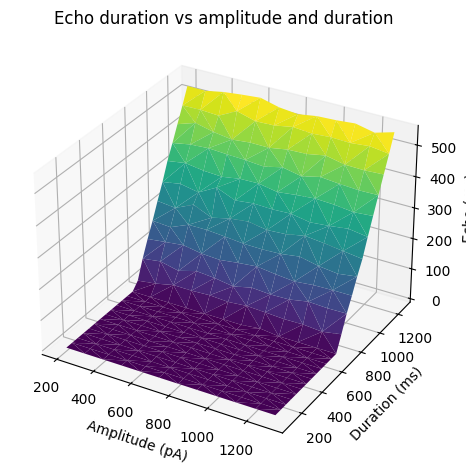

In [47]:
import matplotlib.pyplot as plt

df = pd.read_csv('echo_amp_dur.csv')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(df['amp_pA'], df['dur_ms'], df['echo_ms'],
                cmap='viridis', linewidth=0.2)
ax.set_xlabel('Amplitude (pA)')
ax.set_ylabel('Duration (ms)')
ax.set_zlabel('Echo (ms)')
plt.title('Echo duration vs amplitude and duration')
plt.tight_layout()
plt.show()

In [64]:
df_w = pd.read_csv('echo_vs_w.csv')
plt.figure()
plt.plot(df_w['BASE_W'], df_w['echo_ms'], marker='o')
plt.xlabel('BASE_W')
plt.ylabel('Echo duration (ms)')
plt.title('Echo vs BASE_W')
plt.grid(True)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'echo_w.csv'

## PREVIOUS CODE

In [ ]:
# connect neurons based on connectivity matrices, 
# for each conn type, create a connection if weight > 0 
for pre_id in aa.index:
    for post_id in aa.columns:
        # get the index in the NEST neuron list
        pre_idx = node_index[int(pre_id)]
        post_idx = node_index[int(post_id)]
        
        # get the actual neuron objects
        pre_neuron = neurons[pre_idx:pre_idx+1]
        post_neuron = neurons[post_idx:post_idx+1]
        
        # type aa
        weight_aa = aa.loc[pre_id, post_id]
        if weight_aa > 0:
            # connect with scaled weight and fixed delay
            nest.Connect(
                pre_neuron,
                post_neuron,
                syn_spec={'weight': 0.5 * weight_aa, 'delay': 1.5}
            )
        
        # type ad
        weight_ad = ad.loc[pre_id, post_id]
        if weight_ad > 0:
            nest.Connect(
                pre_neuron,
                post_neuron,
                syn_spec={'weight': 0.5 * weight_ad, 'delay': 1.5}
            )
        
        # type da
        weight_da = da.loc[pre_id, post_id]
        if weight_da > 0:
            nest.Connect(
                pre_neuron,
                post_neuron,
                syn_spec={'weight': 0.5 * weight_da, 'delay': 1.5}
            )
        
        # type dd
        weight_dd = dd.loc[pre_id, post_id]
        if weight_dd > 0:
            nest.Connect(
                pre_neuron,
                post_neuron,
                syn_spec={'weight': 0.5 * weight_dd, 'delay': 1.5}
            )

In [ ]:
# set up spike recording device and connect to all neurons
spike_recorder = nest.Create('spike_recorder')
nest.Connect(neurons, spike_recorder)

In [ ]:
# select random neurons for stimulation
import random 

num_neurons_to_stimulate = 10
stimulated_indices = random.sample(range(N_neurons), num_neurons_to_stimulate)
stimulated_neurons = [neurons[i] for i in stimulated_indices]
stimulated_neurons

In [ ]:
#  set up a multimeter to record membrane potential from one neuron that were activated
multimeter = nest.Create('multimeter', params={'record_from': ['V_m'], 'interval': 0.1})
nest.Connect(multimeter, stimulated_neurons[0][0:1])

In [ ]:
# create a DC generator for external stimulation
dc = nest.Create('dc_generator', params={'amplitude': 400.0, 'start': 50.0, 'stop': 150.0})

In [ ]:
# connect DC generator to each selected neuron
for i in range(len(stimulated_neurons)):
    nest.Connect(dc, stimulated_neurons[i][0:1])

In [ ]:
# run the simulation for the specified time
sim_time = 200.0
nest.Simulate(sim_time)

In [ ]:
# print spike events recorded during simulation
spikes = nest.GetStatus(spike_recorder, 'events')[0]
print(spikes)

In [ ]:
print(nest.Models())

In [ ]:
# print voltage recordings from the multimeter
dmm = nest.GetStatus(multimeter)[0]
Vms = dmm['events']['V_m']
for vm in Vms:
    print(vm)